# Import everything and initialize

In [1]:
import pandas as pd
import geopandas as gpd 
import plotly.express as px
import matplotlib.pyplot as plt
import folium as fm
from folium.plugins import HeatMap
import numpy as np
from pysal.explore import esda
from libpysal.weights import KNN
import libpysal
import seaborn as sns
import contextily
import pymc as pm
import arviz as az
import bambi as bmb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.formula.api import glm
from statsmodels.genmod.families import NegativeBinomial
from patsy import dmatrices
import plotly.graph_objects as go

/Users/jackfukushima/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Get it going

In [2]:

evictions = pd.read_csv('/Users/jackfukushima/Python/data/eviction_data_concat.csv')
evictions_geocoded = pd.read_csv('/Users/jackfukushima/Python/data/evictions_geocoded.csv')
svi_la = gpd.read_file('/Users/jackfukushima/Python/data/LACounty_SVI_gdb_-2756885108865704561.geojson')
acs_housing = pd.read_csv(
    '/Users/jackfukushima/Python/data/DP04 2010-2022 Datasets/ACSDP5Y2022.DP04-Data.csv',
    usecols=['FIPS','DP04_0126E'],
    dtype={
        'FIPS':'str',
        'DP04_0126E':'int'
    }
)


In [3]:

# Convert evictions 'Address' to string
evictions['Address'] = evictions['Address'].astype(str)

# Create new column in evictions_geocode with matching name 'Address' and make sure it's a string
evictions_geocoded['Address'] = evictions_geocoded['input_string'].astype(str)
evictions_matched = evictions_geocoded.merge(evictions,left_index=True,right_index=True)
evic_geo_match = gpd.GeoDataFrame(evictions_matched,geometry=gpd.points_from_xy(evictions_matched['longitude'],evictions_matched['latitude']),crs='4326')

evic_geo_match.head()

svi_la = pd.merge(svi_la,acs_housing,on='FIPS')



In [4]:
svi_la = svi_la[[
    'geometry',
    'FIPS',
    'LOCATION',
    'AREA_SQMI',
    'E_TOTPOP',
    'E_HU',
    'E_HH',
    'E_POV',
    'E_UNEMP',
    'E_PCI',
    'E_NOHSDP',
    'E_AGE65',
    'E_AGE17',
    'E_DISABL',
    'E_SNGPNT',
    'E_MINRTY',
    'E_LIMENG',
    'E_MUNIT',
    'E_MOBILE',
    'E_CROWD',
    'E_NOVEH',
    'E_GROUPQ',
    'EP_POV',
    'EP_UNEMP',
    'EP_PCI',
    'DP04_0126E'
]].copy()
svi_la = svi_la.rename(
    columns={
    'LOCATION':'location',
    'AREA_SQMI':'area_sqmile',
    'E_TOTPOP':'total_pop',
    'E_HU':'housing_units',
    'E_HH':'households',
    'E_POV':'pct_below150',
    'E_UNEMP':'unemployed',
    'E_PCI':'cost_burdened_low_income',
    'E_NOHSDP':'no_high_school',
    'E_AGE65':'persons_over65',
    'E_AGE17':'persons_under17',
    'E_DISABL':'disabled_pop',
    'E_SNGPNT':'single_parent',
    'E_MINRTY':'minority_pop',
    'E_LIMENG':'limited_eng',
    'E_MUNIT':'10_units_plus',
    'E_MOBILE':'mobile_homes',
    'E_CROWD':'crowded_units',
    'E_NOVEH':'no_vehicle',
    'E_GROUPQ':'persons_group_quarters',
    'EP_POV':'pct_pov',
    'EP_UNEMP':'pct_unemp',
    'EP_PCI':'pct_cost_burdened_low_income',
    'DP04_0126E':'rental_occupied'
})

In [5]:
svi_la = svi_la.to_crs(epsg='4326')
evictions_geo = evictions_geocoded[['latitude','longitude']]
evictions_geo = evictions_geo.dropna()
svi_la


geometry         FIPS  \
0     POLYGON ((-118.30077 34.25961, -118.30077 34.2...  06037101110   
1     POLYGON ((-118.30321 34.27334, -118.29971 34.2...  06037101122   
2     POLYGON ((-118.28594 34.25228, -118.28594 34.2...  06037101220   
3     POLYGON ((-118.27824 34.25166, -118.27693 34.2...  06037101300   
4     POLYGON ((-118.32239 34.24964, -118.31672 34.2...  06037101400   
...                                                 ...          ...   
1992  POLYGON ((-118.30885 33.77262, -118.30894 33.7...  06037980015   
1993  POLYGON ((-118.59806 34.07622, -118.59564 34.0...  06037980019   
1994  POLYGON ((-118.51850 34.18499, -118.51849 34.1...  06037980024   
1995  POLYGON ((-118.35174 34.28248, -118.32684 34.2...  06037980026   
1996  POLYGON ((-118.29106 33.75378, -118.29051 33.7...  06037980031   

                                               location  area_sqmile  \
0     Census Tract 1011.10, Los Angeles County, Cali...     0.441084   
1     Census Tract 1011.22, Los Angeles County, Cali...     1.020871   
2     Census Tract 1012.20, Los Angeles County, Cali...     0.269841   
3     Census Tract 1013, Los Angeles County, California     0.996612   
4     Census Tract 1014, Los Angeles County, California     2.436325   
...                                                 ...          ...   
1992  Census Tract 9800.15, Los Angeles County, Cali...     2.003458   
1993  Census Tract 9800.19, Los Angeles County, Cali...    17.069705   
1994  Census Tract 9800.24, Los Angeles County, Cali...     3.088369   
1995  Census Tract 9800.26, Los Angeles County, Cali...     5.353546   
1996  Census Tract 9800.31, Los Angeles County, Cali...     4.823257   

      total_pop  housing_units  households  pct_below150  unemployed  \
0          4314           1743        1596           679         166   
1          3239           1391        1256           109          94   
2          3497           1328        1294           524         132   
3          4297           1584        1435           391         125   
4          3851           1614        1473           321         150   
...         ...            ...         ...           ...         ...   
1992        556            300         276           108          38   
1993        151             70          70             6           8   
1994        264             86          86             8           5   
1995         37              8           8             0           0   
1996       1113             24          24             0           0   

      cost_burdened_low_income  ...  limited_eng  10_units_plus  mobile_homes  \
0                        26996  ...          425            220            29   
1                        46974  ...          127              0             0   
2                        21844  ...          647            339             0   
3                        35120  ...          194             36             7   
4                        34799  ...          308            130            13   
...                        ...  ...          ...            ...           ...   
1992                     34087  ...           11            265             0   
1993                    102044  ...            9              4             0   
1994                     43613  ...            0              8             0   
1995                     27446  ...            0              0             0   
1996                      9765  ...           50              0             0   

      crowded_units  no_vehicle  persons_group_quarters  pct_pov  pct_unemp  \
0                82         123                      95     16.1        7.7   
1                62           7                       5      3.4        4.6   
2               152         113                       0     15.0        7.8   
3                34          66                      47      9.2        5.7   
4                39         121                      24      8.4        7.3   
...  

In [29]:
address_ct = evic_geo_match['formatted_address'].value_counts().reset_index(name='count')
address_df = address_ct.merge(evic_geo_match,how='left',on='formatted_address')
address_df = address_df.drop_duplicates(subset='formatted_address')
address_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13661 entries, 0 to 76759
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   formatted_address  13661 non-null  object  
 1   count              13661 non-null  int64   
 2   Unnamed: 0         13661 non-null  int64   
 3   latitude           13661 non-null  float64 
 4   longitude          13661 non-null  float64 
 5   accuracy           13661 non-null  object  
 6   google_place_id    13661 non-null  object  
 7   type               13661 non-null  object  
 8   postcode           13637 non-null  float64 
 9   input_string       13661 non-null  object  
 10  number_of_results  13661 non-null  int64   
 11  status             13661 non-null  object  
 12  Address_x          13661 non-null  object  
 13  Notice Date        13659 non-null  object  
 14  Date Received      13661 non-null  object  
 15  Eviction Category  13661 non-null  object  
 16  Cause    

In [33]:
address_df = gpd.GeoDataFrame(address_df, geometry='geometry')
evictions_address = gpd.sjoin(address_df,svi_la,how='right')
evictions_address.columns.to_list()
evictions_address=evictions_address.drop_duplicates(subset = 'formatted_address')
evictions_address.formatted_address = evictions_address.formatted_address.astype(str)
evictions_address.formatted_address.is_unique

True

In [25]:
census_evic_counts = evictions_address.groupby('FIPS').agg({
 'formatted_address':', '.join,
 'count':'sum',
 'postcode':'first',
 'geometry':'first',
 'location':'first',
 'area_sqmile':'first',
 'total_pop':'first',
 'housing_units':'first',
 'households':'first',
 'pct_below150':'first',
 'unemployed':'first',
 'cost_burdened_low_income':'first',
 'no_high_school':'first',
 'persons_over65':'first',
 'persons_under17':'first',
 'disabled_pop':'first',
 'single_parent':'first',
 'minority_pop':'first',
 'limited_eng':'first',
 '10_units_plus':'first',
 'mobile_homes':'first',
 'crowded_units':'first',
 'no_vehicle':'first',
 'persons_group_quarters':'first',
 'pct_pov':'first',
 'pct_unemp':'first',
 'pct_cost_burdened_low_income':'first',
 'rental_occupied':'first'
}).reset_index()



In [23]:
census_evic_counts = evictions_address.dissolve(by='FIPS')

In [10]:
census_evic_counts.shape

(921, 29)

In [11]:
census_evic_counts['count_norm'] = census_evic_counts['count']/census_evic_counts['rental_occupied']

In [12]:

m = fm.Map([34,-118])

evictions_geocoded.info()

HeatMap(evictions_geo).add_to(m)
m.save('map.html')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77091 entries, 0 to 77090
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         77091 non-null  int64  
 1   formatted_address  76760 non-null  object 
 2   latitude           76760 non-null  float64
 3   longitude          76760 non-null  float64
 4   accuracy           76760 non-null  object 
 5   google_place_id    76760 non-null  object 
 6   type               76760 non-null  object 
 7   postcode           76458 non-null  float64
 8   input_string       77091 non-null  object 
 9   number_of_results  77091 non-null  int64  
 10  status             77091 non-null  object 
 11  Address            77091 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 7.1+ MB


<Axes: >

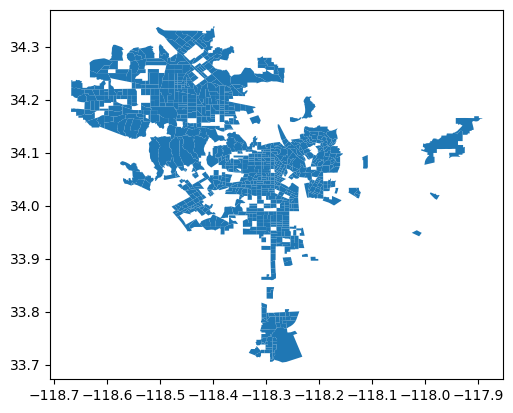

In [13]:
census_evic_counts = gpd.GeoDataFrame(census_evic_counts,geometry=census_evic_counts['geometry'])
census_evic_counts.plot()

In [14]:
census_evic_counts.shape

(921, 30)

In [15]:
count_mean = census_evic_counts['count_norm'].mean()
count_median = census_evic_counts['count_norm'].median()
count_std = np.std(census_evic_counts['count_norm'])

print(count_mean), print(count_std), print(count_median)

0.07195188045498911
0.11666862954415275
0.036939313984168866


(None, None, None)

In [16]:
evic_geo_match['notice_date_dt'] = pd.to_datetime(evic_geo_match['Notice Date'], format='%m/%d/%y')
evic_geo_match['notice_date_dt']
evic_geo_match = evic_geo_match[evic_geo_match['notice_date_dt'].dt.year >= 2023 ]
address_count_grpd = evic_geo_match.value_counts(['notice_date_dt']).reset_index(name='count')
address_count_grpd


notice_date_dt  count
0       2023-03-08   1666
1       2023-04-05   1640
2       2023-04-06   1549
3       2023-05-04   1494
4       2023-04-07   1448
..             ...    ...
341     2023-12-25      1
342     2023-01-09      1
343     2023-01-08      1
344     2023-01-06      1
345     2023-07-23      1

[346 rows x 2 columns]

In [17]:
fig_date_year = px.bar(
    address_count_grpd,
    x = 'notice_date_dt',
    y='count',
    text='count',
    title='Eviction filings in 2023'
)
fig_date_year.add_annotation(x='2023-04-01', y=0,
            text="End of COVID Rent Protections",
            showarrow=True,
            arrowhead=2,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=-20,
            ay=-200,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ffffff",
            opacity=0.8)
fig_date_year.show()

In [18]:
census_evic_counts.geometry
census_evic_counts = census_evic_counts.set_crs(epsg=4326)

In [19]:
# Generate W from the GeoDataFrame
w = KNN.from_dataframe(census_evic_counts,geom_col='geometry',k=8)
# Row-standardization
w.transform = "R"

In [20]:
census_evic_counts["w_count"] = libpysal.weights.lag_spatial(w, census_evic_counts['count_norm'])
census_evic_counts['count_std'] = census_evic_counts['count_norm'] - census_evic_counts['count_norm'].mean()
census_evic_counts["w_count_std"] = libpysal.weights.lag_spatial(w, census_evic_counts['count_std'])

fig = px.histogram(census_evic_counts,x=census_evic_counts['w_count'])
fig2 = px.histogram(census_evic_counts,x=census_evic_counts['count_std'])
fig3 = px.histogram(census_evic_counts,x=census_evic_counts['w_count_std'])

fig.show()
fig2.show()
fig3.show()


In [21]:
census_evic_counts["w_count_log"] = np.log(libpysal.weights.lag_spatial(w, census_evic_counts['count_norm']))
census_evic_counts["w_count_log_std"] = np.log(libpysal.weights.lag_spatial(w, census_evic_counts['count_std']))
census_evic_counts['count_std_log'] = np.log(census_evic_counts['count_norm'] - census_evic_counts['count_norm'].mean())

fig = px.histogram(census_evic_counts,x=census_evic_counts['w_count_log'])
fig2 = px.histogram(census_evic_counts,x=census_evic_counts['count_std_log'])

fig.show()
fig2.show()


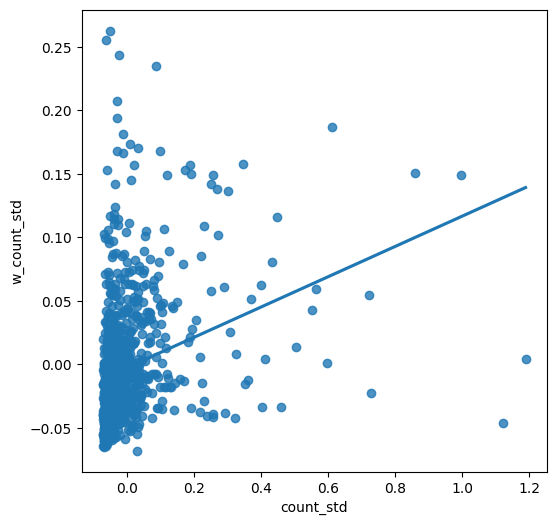

In [22]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="count_std", y="w_count_std", data=census_evic_counts, ci=None
)

plt.show()

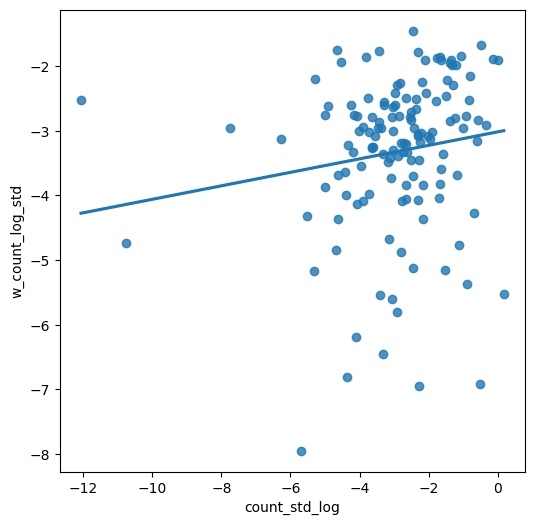

In [23]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="count_std_log", y="w_count_log_std", data=census_evic_counts, ci=None
)

plt.show()

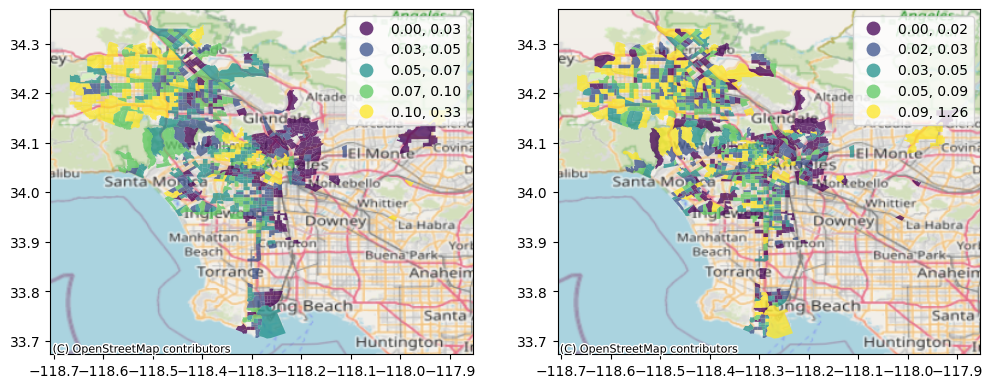

In [24]:
f, axs = plt.subplots(1,2,figsize=(12, 6))
ax1, ax2 = axs

census_evic_counts.plot(
    column="w_count",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)

census_evic_counts.plot(
    column="count_norm",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
contextily.add_basemap(
    ax1,
    crs=census_evic_counts.crs,
    source=contextily.providers.OpenStreetMap.Mapnik,
    zoom=9
)
contextily.add_basemap(
    ax2,
    crs=census_evic_counts.crs,
    source=contextily.providers.OpenStreetMap.Mapnik,
    zoom=9
)
plt.show()

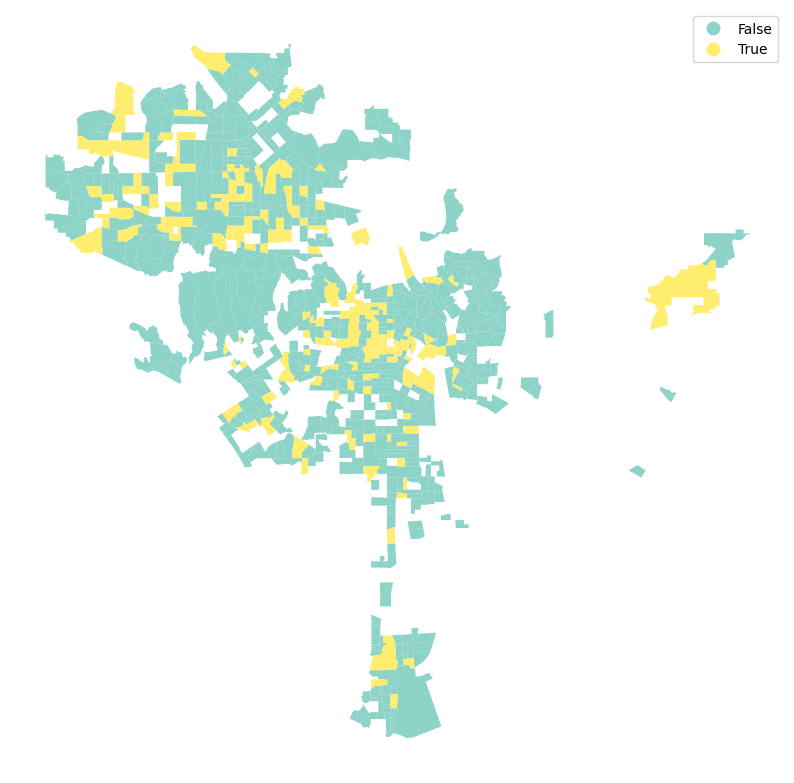

In [25]:
# Create a high eviction rate 

evic_mean = census_evic_counts['count'].mean()
census_evic_counts['evic_risk'] = census_evic_counts['count']>evic_mean
census_evic_counts['evic_risk']

f, ax = plt.subplots(1,figsize=(10,10))

census_evic_counts.plot(
    ax=ax,
    column='evic_risk',
    categorical=True,
    legend=True,
    colormap='Set3'
)
ax.set_axis_off()
plt.show()

In [26]:
w.transform = "O"
jc = esda.join_counts.Join_Counts(census_evic_counts["evic_risk"], w)
jc

In [27]:
jc_table = pd.DataFrame([
    ['Statistic','Low-Low','Low-High','High-High','Sum'],
    ['Actual',jc.bb,jc.bw,jc.ww,(jc.bb+jc.bw+jc.ww)],
    ['Predicted',jc.mean_bb,jc.mean_bw,'na','na'],
    ['p-values',jc.p_sim_bb,jc.p_sim_bw,'na','na']
])

In [28]:
jc_table

0          1            2          3       4
0  Statistic    Low-Low     Low-High  High-High     Sum
1     Actual      401.0       1111.0     2172.0  3684.0
2  Predicted  237.44995  1397.288789         na      na
3   p-values      0.001          1.0         na      na

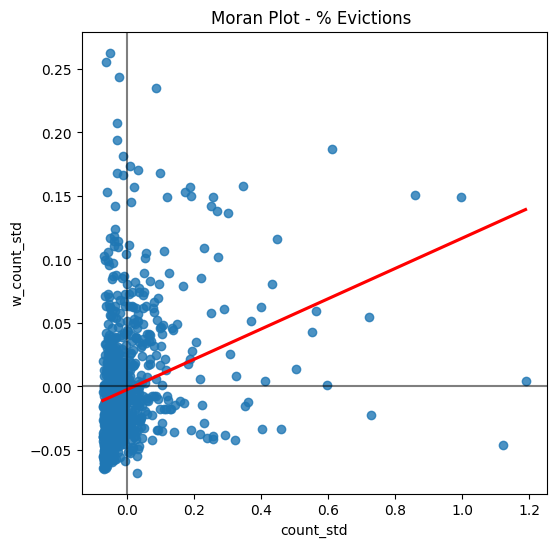

In [29]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="count_std",
    y="w_count_std",
    ci=None,
    data=census_evic_counts,
    line_kws={"color": "r"},
)

ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Evictions ")
plt.show()

In [30]:
w.transform = "R"
moran = esda.moran.Moran(census_evic_counts["count_norm"], w)
moran_log = esda.moran.Moran(np.log(census_evic_counts['count_norm']),w)

In [31]:

moran.I, moran.z_sim

(0.11923554308065092, 7.68361586185404)

In [32]:
moran.p_sim

0.001

In [33]:
census_evic_counts.columns.to_list()

['FIPS',
 'formatted_address',
 'count',
 'postcode',
 'geometry',
 'location',
 'area_sqmile',
 'total_pop',
 'housing_units',
 'households',
 'pct_below150',
 'unemployed',
 'cost_burdened_low_income',
 'no_high_school',
 'persons_over65',
 'persons_under17',
 'disabled_pop',
 'single_parent',
 'minority_pop',
 'limited_eng',
 '10_units_plus',
 'mobile_homes',
 'crowded_units',
 'no_vehicle',
 'persons_group_quarters',
 'pct_pov',
 'pct_unemp',
 'pct_cost_burdened_low_income',
 'rental_occupied',
 'count_norm',
 'w_count',
 'count_std',
 'w_count_std',
 'w_count_log',
 'w_count_log_std',
 'count_std_log',
 'evic_risk']

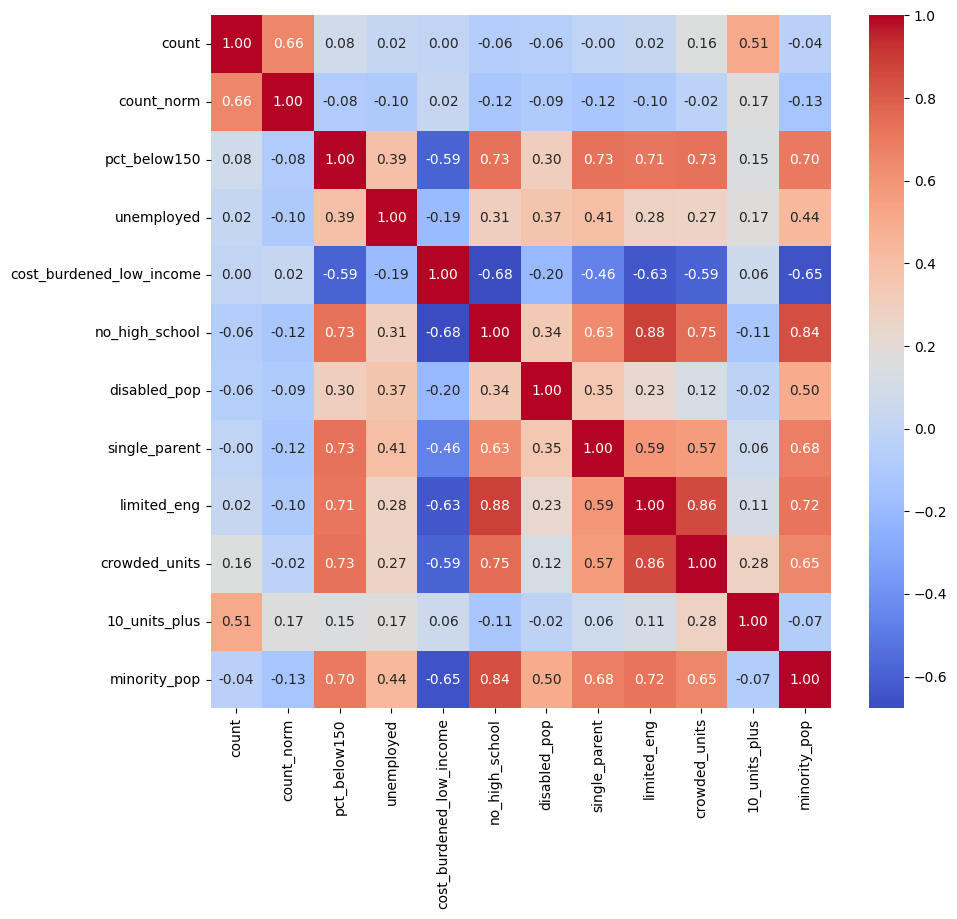

In [34]:
census_vars = census_evic_counts[[
    'count',
    'count_norm',
    'pct_below150',
    'unemployed',
    'cost_burdened_low_income',
    'no_high_school',
    'disabled_pop',
    'single_parent',
    'limited_eng',
    'crowded_units',
    '10_units_plus',
    'minority_pop'
]]
corr = census_vars.corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr,annot=True,cmap='coolwarm',fmt='.2f')
plt.show()

In [35]:
X = census_vars.values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
census_scaled = pd.DataFrame(X_scaled,columns=census_vars.columns)
census_scaled


count  count_norm  pct_below150  unemployed  cost_burdened_low_income  \
0    0.001931    0.003664      0.190409    0.226467                  0.137487   
1    0.003861    0.016745      0.030566    0.128240                  0.277305   
2    0.007722    0.012615      0.146943    0.180082                  0.101431   
3    0.016088    0.069772      0.109647    0.170532                  0.194344   
4    0.001287    0.005232      0.090017    0.204638                  0.192097   
..        ...         ...           ...         ...                       ...   
916  0.001931    0.091455      0.001963    0.000000                  0.039423   
917  0.001287    0.022974      0.038138    0.001364                  0.059047   
918  0.047619    0.127507      0.030286    0.051842                  0.187114   
919  0.003218    0.495384      0.002243    0.006821                  0.253783   
920  0.002574    0.634091      0.000000    0.000000                  0.016895   

     no_high_school  disabled_pop  single_parent  limited_eng  crowded_units  \
0          0.207361      0.448751       0.180867     0.185428       0.104592   
1          0.066482      0.304910       0.147982     0.055410       0.079082   
2          0.203799      0.502153       0.198804     0.282286       0.193878   
3          0.143253      0.521102       0.059791     0.084642       0.043367   
4          0.102097      0.469423       0.174888     0.134380       0.049745   
..              ...           ...            ...          ...            ...   
916        0.007123      0.005168       0.007474     0.000000       0.006378   
917        0.018599      0.039621       0.000000     0.013089       0.028061   
918        0.024139      0.034453       0.125561     0.004799       0.073980   
919        0.006332      0.020672       0.000000     0.000000       0.000000   
920        0.037198      0.000000       0.028401     0.021815       0.000000   

     10_units_plus  minority_pop  
0         0.059459      0.231562  
1         0.000000      0.053416  
2         0.091622      0.232240  
3         0.009730      0.095445  
4         0.035135      0.167028  
..             ...           ...  
916       0.000000      0.000000  
917       0.005135      0.007321  
918       0.071622      0.051790  
919       0.002162      0.001898  
920       0.000000      0.084599  

[921 rows x 12 columns]

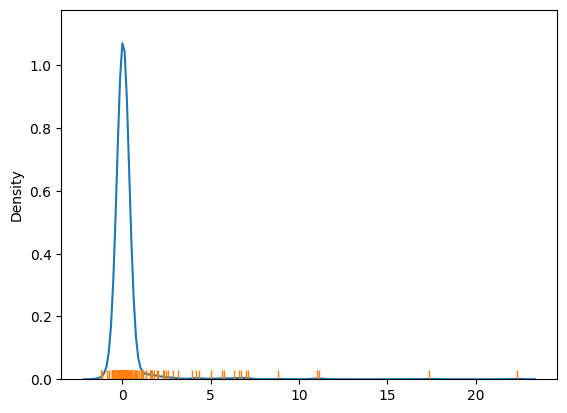

In [48]:
lisa = esda.moran.Moran_Local(census_scaled["count"], w)
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

In [36]:
vif = pd.Series([variance_inflation_factor(census_scaled.values,i) for i in range(census_scaled.shape[1])],index=census_scaled.columns)

In [37]:
vif

count                        3.132061
count_norm                   2.498603
pct_below150                10.964934
unemployed                   6.379221
cost_burdened_low_income     2.280543
no_high_school              28.113611
disabled_pop                 9.590771
single_parent                7.715610
limited_eng                 22.400370
crowded_units               14.547456
10_units_plus                4.001256
minority_pop                24.355695
dtype: float64

In [38]:
table = census_scaled.describe()
table

count  count_norm  pct_below150  unemployed  \
count  921.000000  921.000000    921.000000  921.000000   
mean     0.037672    0.057030      0.201964    0.200449   
std      0.074818    0.092523      0.136975    0.107716   
min      0.000000    0.000000      0.000000    0.000000   
25%      0.006435    0.015495      0.093382    0.125512   
50%      0.016731    0.029279      0.172462    0.182810   
75%      0.037967    0.060970      0.284352    0.264666   
max      1.000000    1.000000      1.000000    1.000000   

       cost_burdened_low_income  no_high_school  disabled_pop  single_parent  \
count                921.000000      921.000000    921.000000     921.000000   
mean                   0.180226        0.249946      0.331386       0.190918   
std                    0.168757        0.178736      0.143070       0.131944   
min                    0.000000        0.000000      0.000000       0.000000   
25%                    0.068901        0.092996      0.226529       0.091181   
50%                    0.121866        0.232687      0.310939       0.162930   
75%                    0.232941        0.379501      0.417743       0.269058   
max                    1.000000        1.000000      1.000000       1.000000   

       limited_eng  crowded_units  10_units_plus  minority_pop  
count   921.000000     921.000000     921.000000    921.000000  
mean      0.251144       0.227289       0.127003      0.369321  
std       0.190573       0.178849       0.133933      0.187133  
min       0.000000       0.000000       0.000000      0.000000  
25%       0.080716       0.080357       0.025405      0.223834  
50%       0.224258       0.197704       0.081622      0.359816  
75%       0.374782       0.330357       0.194054      0.499864  
max       1.000000       1.000000       1.000000      1.000000

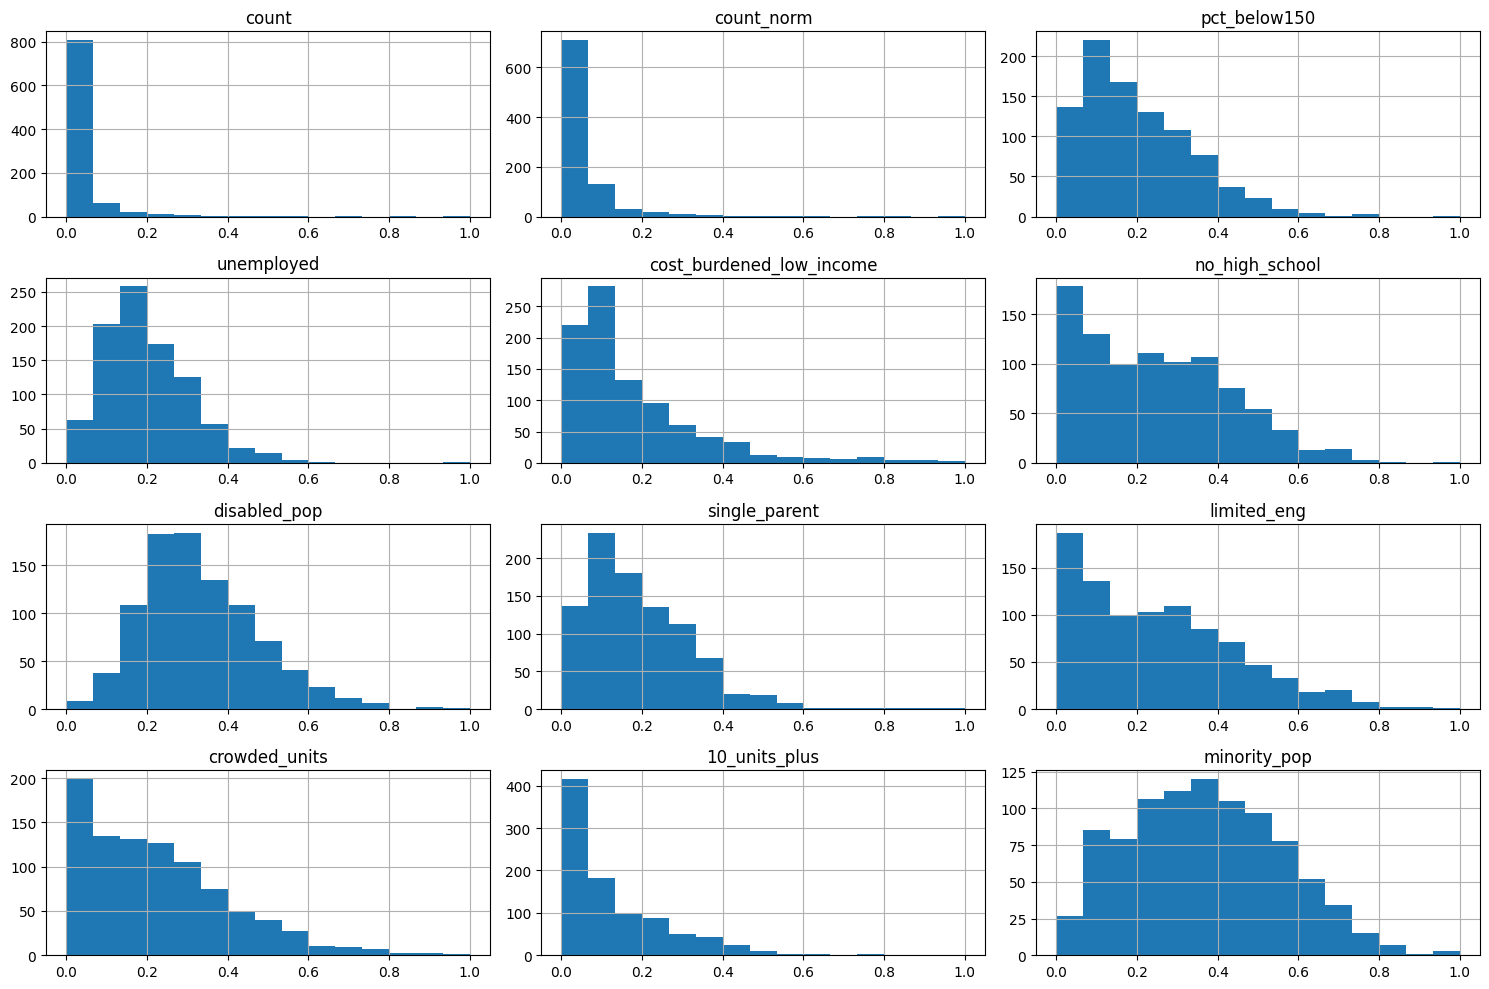

In [39]:
census_scaled.hist(bins=15,figsize=(15,10))
plt.tight_layout()
plt.show()

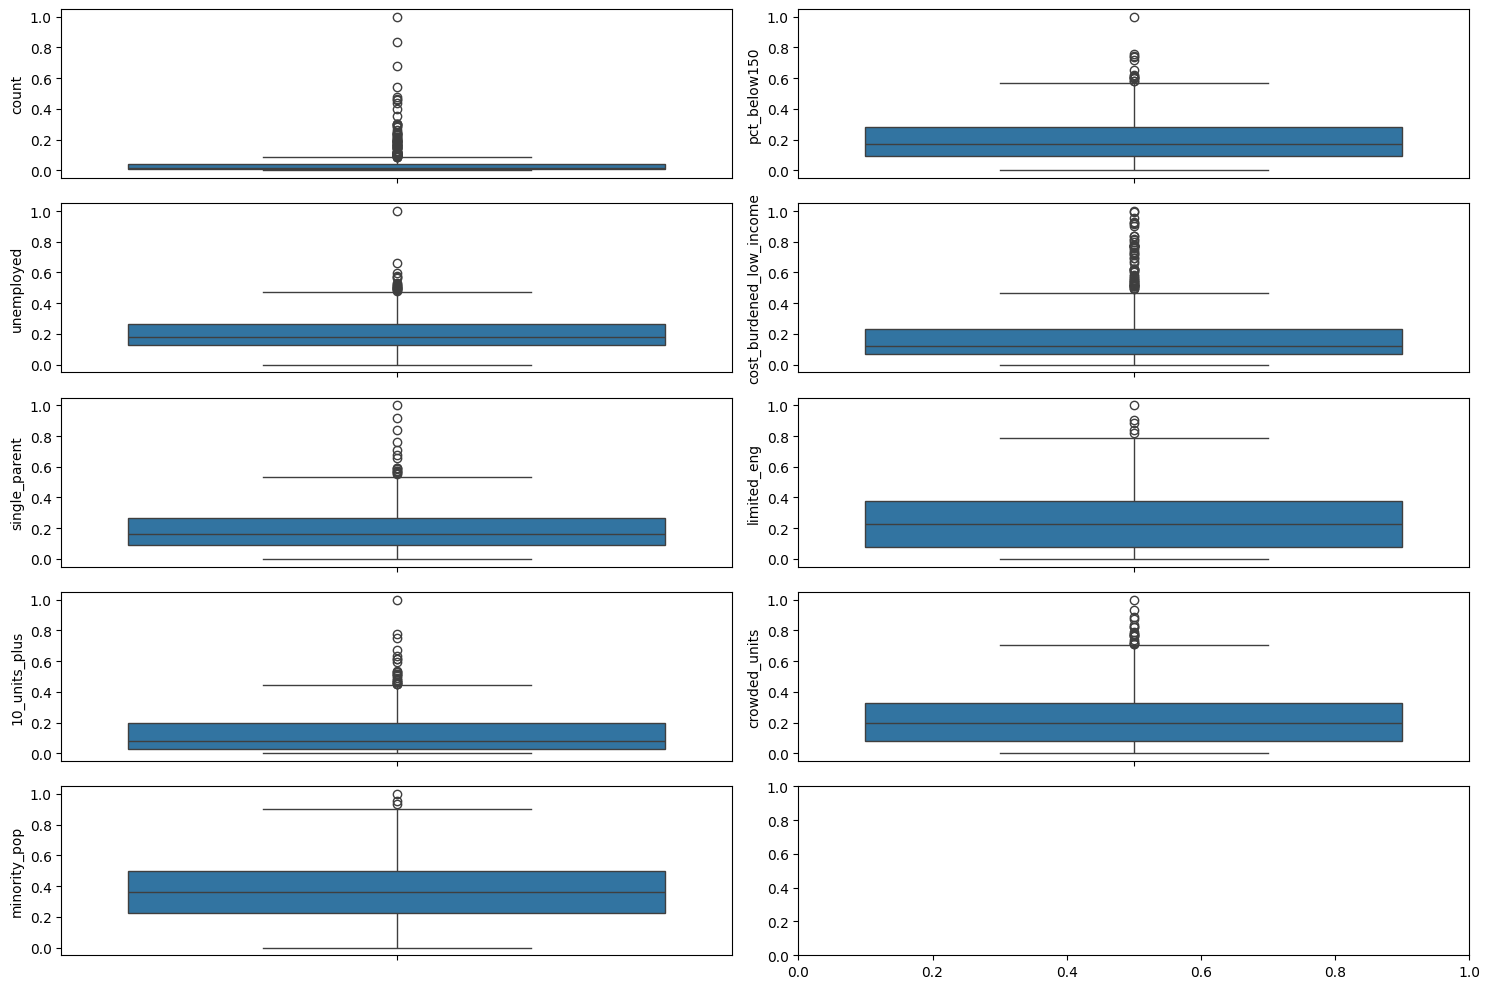

In [40]:
fig, ax = plt.subplots(5,2,figsize=(15,10))
ax = ax.flatten()
num_vars = [    
    'count',
    'pct_below150',
    'unemployed',
    'cost_burdened_low_income',
    'single_parent',
    'limited_eng',
    '10_units_plus',
    'crowded_units',
    'minority_pop'
    ]
for i, var in enumerate(num_vars):
    sns.boxplot(y=var,data=census_scaled,ax=ax[i])
   
plt.tight_layout()
plt.show()

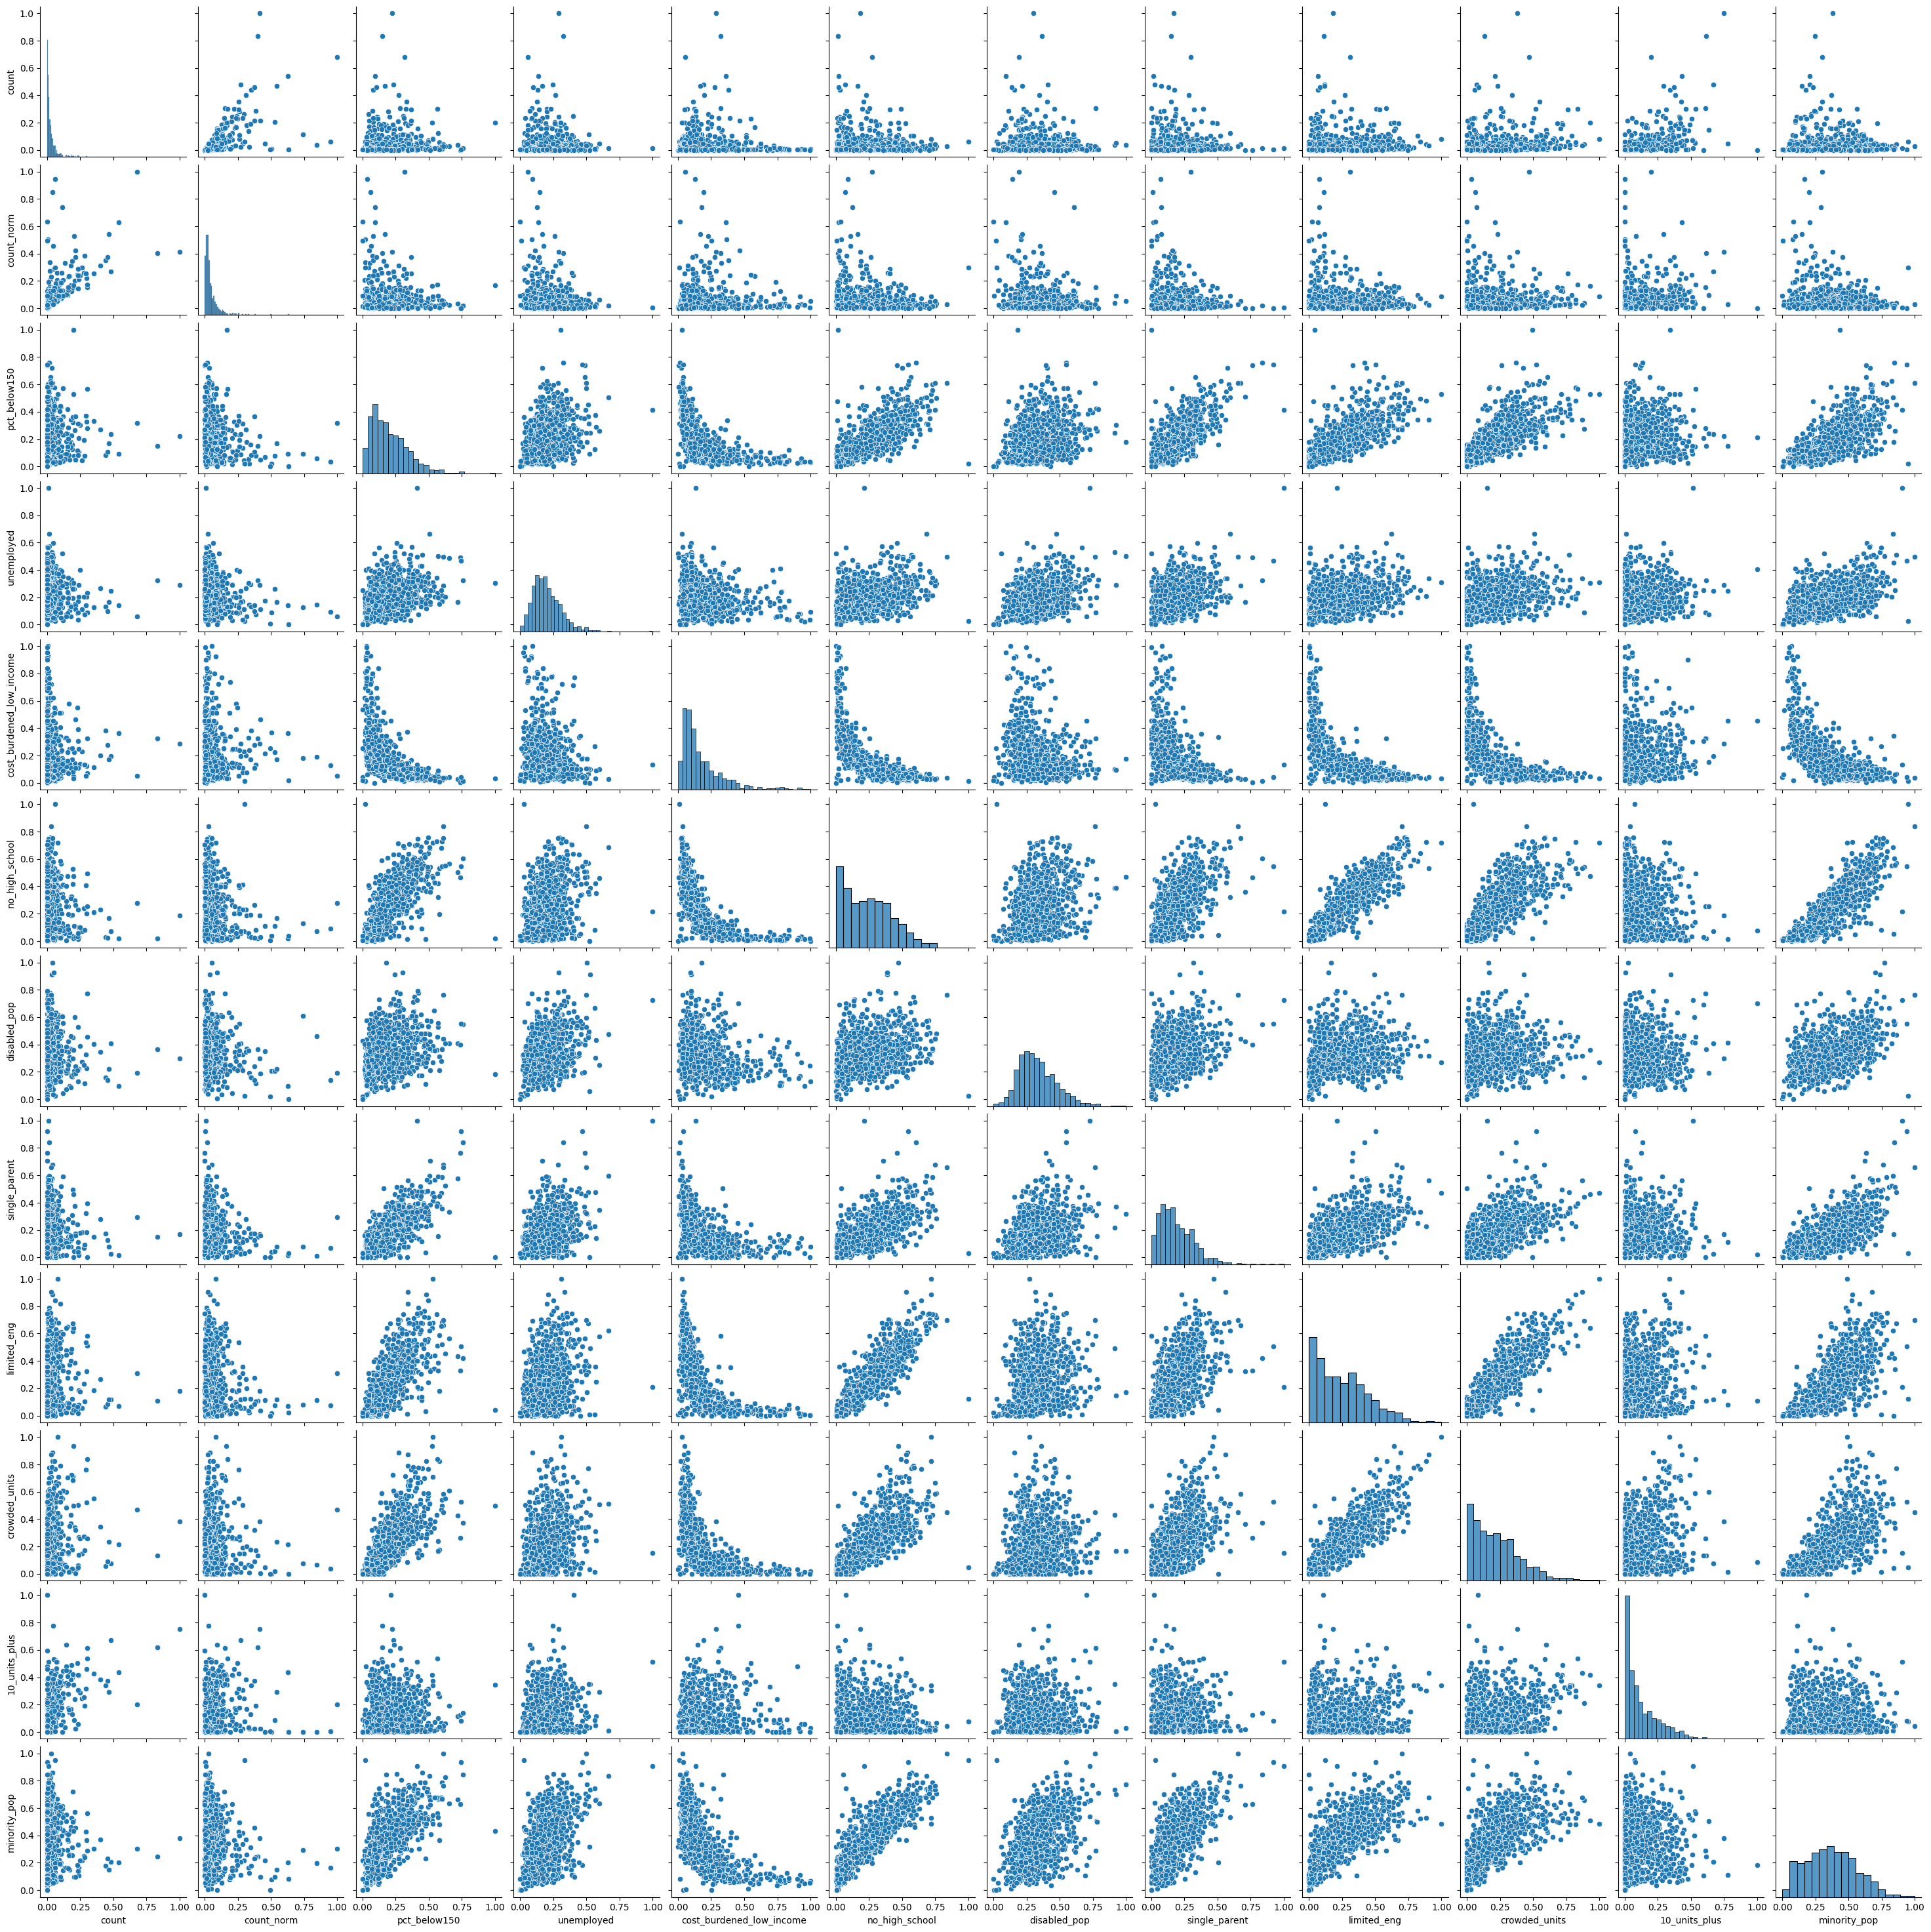

In [41]:
sns.pairplot(census_scaled)
plt.show()

In [42]:
census_scaled = census_scaled.dropna()

In [43]:
census_scaled.shape

(921, 12)

In [44]:
fml = 'count_norm ~ pct_below150 + unemployed + cost_burdened_low_income + no_high_school + limited_eng + minority_pop + disabled_pop + single_parent + limited_eng + crowded_units'

y, X = dmatrices(fml,census_scaled,return_type='dataframe')

X = add_constant(X)
model = sm.GLM(y,X,family=sm.families.NegativeBinomial())

/Users/jackfukushima/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.



In [45]:
results = model.fit()

In [46]:
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             count_norm   No. Observations:                  921
Model:                            GLM   Df Residuals:                      911
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -201.28
Date:                Thu, 15 Feb 2024   Deviance:                       57.129
Time:                        20:08:57   Pearson chi2:                     98.9
No. Iterations:                     5   Pseudo R-squ. (CS):           0.006828
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [115]:

model = bmb.Model(formula=fml,data=census_scaled,dropna=True)
model_fitted = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [count_norm_sigma, Intercept, pct_below150, unemployed, cost_burdened_low_income, no_high_school, limited_eng, minority_pop, disabled_pop, single_parent, crowded_units]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 0.102  0.012   0.079    0.124      0.000    0.000   
pct_below150             -0.004  0.041  -0.088    0.066      0.001    0.001   
unemployed               -0.035  0.033  -0.097    0.024      0.000    0.000   
cost_burdened_low_income -0.058  0.025  -0.108   -0.013      0.000    0.000   
no_high_school           -0.043  0.048  -0.129    0.051      0.001    0.001   
limited_eng              -0.088  0.045  -0.169    0.001      0.001    0.001   
minority_pop             -0.052  0.037  -0.120    0.018      0.001    0.000   
disabled_pop              0.017  0.026  -0.031    0.068      0.000    0.000   
single_parent            -0.052  0.037  -0.120    0.018      0.001    0.000   
crowded_units             0.132  0.036   0.066    0.200      0.001    0.000   
count_norm_sigma          0.091  0.002   0.087    0.095      0.000    0.000   

                          ess_bulk  ess_tail  r_hat

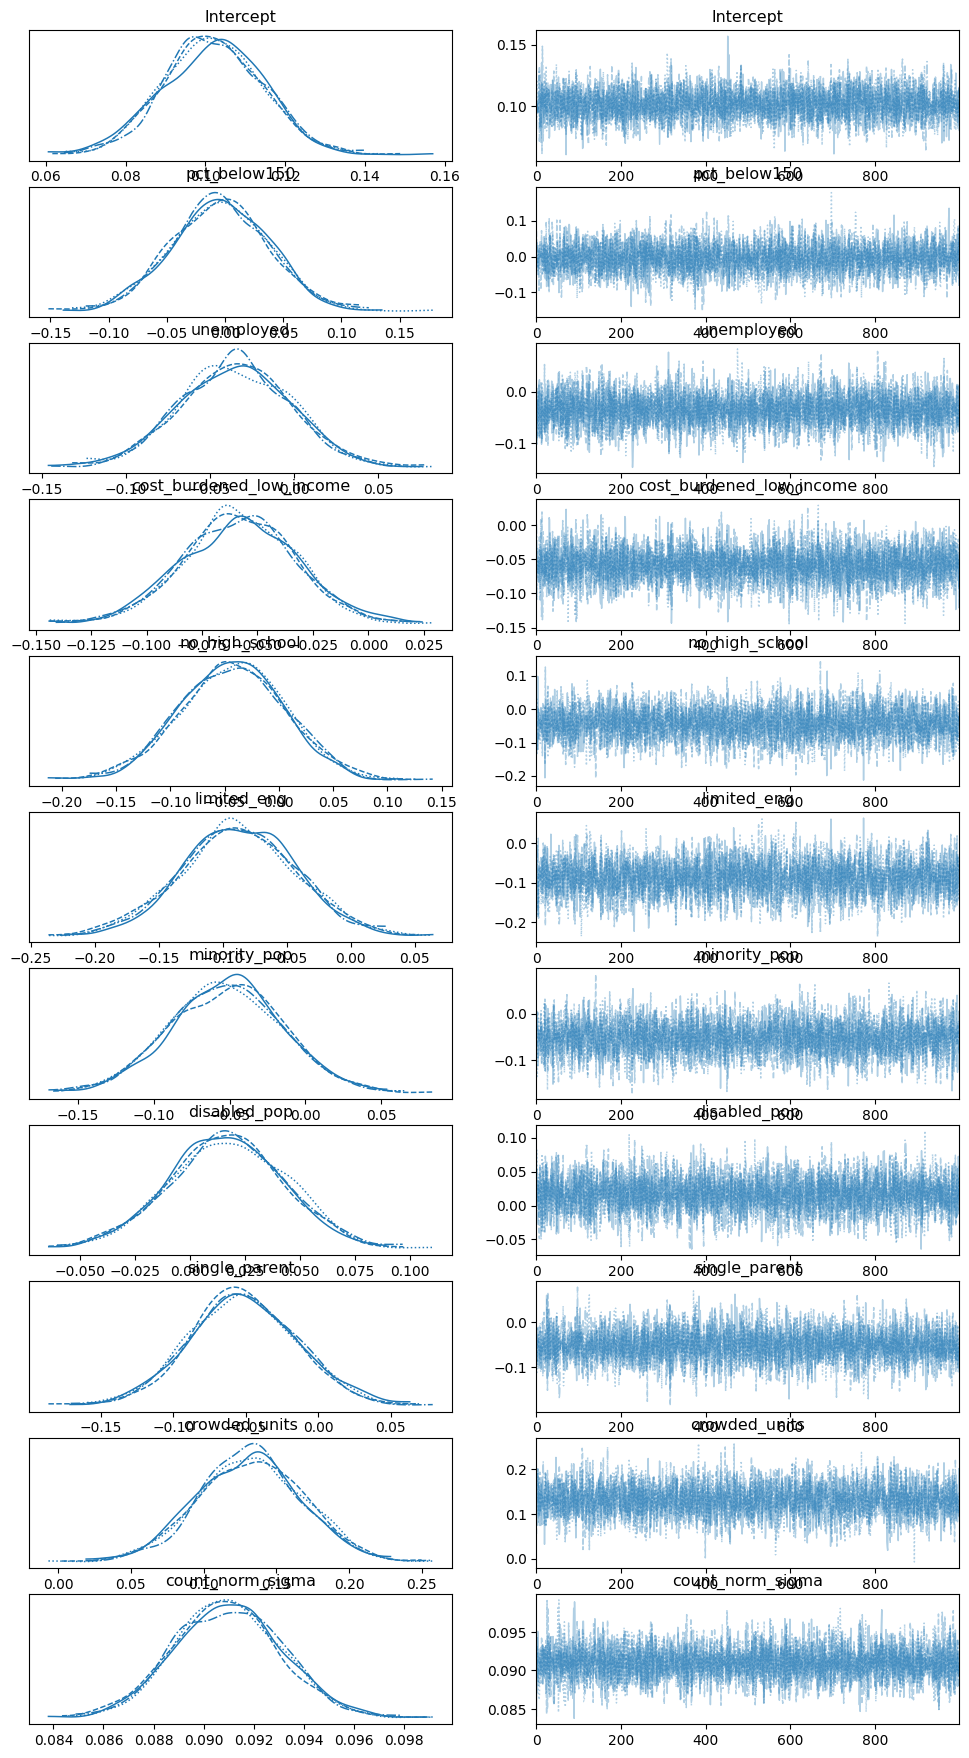

In [116]:
az.plot_trace(model_fitted, compact=True)
print(az.summary(model_fitted))